In [1]:
#Referrence list
## yhat, "Content-based image classification in Python", June 12, 2013, http://blog.yhat.com/posts/image-classification-in-Python.html
## http://stmind.hatenablog.com/entry/2014/01/15/012418

In [12]:
from PIL import Image
import numpy as np
import os
import pandas as pd
import pylab as pl
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
import glob

In [6]:
# Transform images

# Define the size after resizing
standard_size = (300, 167)

# Resize an image to the standard_size (shape = (300, 167, 3))
# and convert it numpy array of RGB pixels
def img_to_matrix(filename):
    img = Image.open(filename)
    img = img.resize(standard_size)
    img_array = np.array(img)
    return img_array

# Flatten a (m, n) numpy array into an array of shape (1, m * n)
def flatten_image(img):
    s = img.shape[0] * img.shape[1] * img.shape[2]
    img_wide = img.reshape(1, s)
    return img_wide[0]

### simple validation

In [19]:
# Store collected images into "data"

def main():
    # List each image files within "damaged" and "undamaged" folders in "image" folder 
    # And label "damaged" to the files in "damaged" folder and "undamaged" to the files in "undamaged" folder 
    images = []
    labels = []
    for image in glob.glob("./images/damaged/*.jpg"):
        images.append(image)
        labels.append("damaged")
    for image in glob.glob("./images/undamaged/*.jpg"):
        images.append(image)
        labels.append("undamaged")
         
    data = []
    
    for image in images:
        # Apply the created functions above
        img = img_to_matrix(image)
        img = flatten_image(img)
        data.append(img)
    # Convert "data" list into numpy array
    data = np.array(data)

    # Divide data into a training set and a test set
    train_frac = 0.75
    is_train = np.random.uniform(0, 1, len(data)) <= train_frac
    # Convert labels into a binary (1 if damaged, otherwise 0)
    y = np.where(np.array(labels) == 'damaged', 1, 0)
    train_x, train_y = data[is_train], y[is_train]
    ## set the test data
    test_x, test_y = data[is_train == False], y[is_train == False]
    
# Create features by reducing the number of dimensions by PCA

## Plot the 1st and 2nd principle components
    pca = PCA(n_components=2)
    X = pca.fit_transform(data)
    df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                       "label": np.where(y == 1, 'damaged', 'undamaged')})
    colors = ['red', 'yellow']
    for label, color in zip(df['label'].unique(), colors):
        mask = df['label'] == label
        pl.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)

    pl.legend()
#    pl.savefig('pca_feature.png') # Save the plot as a png file


# Train a classifier 

## Reduce demension to 5 principles
    pca = PCA(n_components=5)
    train_x = pca.fit_transform(train_x)
    test_x = pca.transform(test_x)

## Fit a classifier to the training set with C=1
    svm = LinearSVC(C=1)
    svm.fit(train_x, train_y)

# Evaluate the model
## Create a confusion matrix
    return pd.crosstab(test_y, svm.predict(test_x), rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,12,10
1,4,4


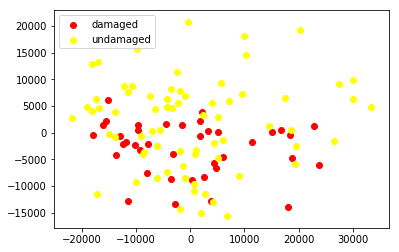

In [20]:
# Perform the analysis above
main()

### 5-fold Cross-validation

In [33]:
# Store collected images into "data"

def cross_validation():
    # List each image files within "damaged" and "undamaged" folders in "image" folder 
    # And label "damaged" to the files in "damaged" folder and "undamaged" to the files in "undamaged" folder 
    images = []
    labels = []
    for image in glob.glob("./images/damaged/*.jpg"):
        images.append(image)
        labels.append("damaged")
    for image in glob.glob("./images/undamaged/*.jpg"):
        images.append(image)
        labels.append("undamaged")
         
    data = []
    
    for image in images:
        # Apply the created functions above
        img = img_to_matrix(image)
        img = flatten_image(img)
        data.append(img)
    # Convert "data" list into numpy array
    data = np.array(data)

    # Divide data into a training set and a test set
    train_frac = 0.75
    is_train = np.random.uniform(0, 1, len(data)) <= train_frac
    # Convert labels into a binary (1 if damaged, otherwise 0)
    y = np.where(np.array(labels) == 'damaged', 1, 0)
    train_x, train_y = data[is_train], y[is_train]
    ## set the test data
    test_x, test_y = data[is_train == False], y[is_train == False]

    ## Reduce demension to 200 principles
    pca = PCA(n_components = 200)
    train_x = pca.fit_transform(train_x)
    test_x = pca.transform(test_x)
    
    # Conduct k-fold cross-validation
    lowest_cross_val_error = np.inf
    best_C = None
    indices = range(len(train_x))
    kf = KFold(n_splits=5, shuffle=True, random_state=94775)
    for C in [1e-2, 1e-1, 1, 10, 100, 1000]:
        errors = []
        for train_indices, val_indices in kf.split(indices):
            classifier = LinearSVC(C=C)
            classifier.fit(train_x[train_indices], train_y[train_indices])
            predicted_val_labels = classifier.predict(train_x[val_indices])
            error = np.mean(predicted_val_labels != train_y[val_indices])
            errors.append(error)
        
        cross_val_error = np.mean(errors)
        print('C:', C, 'cross validation error:', cross_val_error)

        if cross_val_error < lowest_cross_val_error:
            lowest_cross_val_error = cross_val_error
            best_C = C

    print('Best C:', best_C, 'cross validation error:', lowest_cross_val_error)

# Train a classifier with the best C 
# Fit a classifier to the entire training set
    final_svm_classifier = LinearSVC(C=best_C)
    final_svm_classifier.fit(train_x, train_y)
# Evaluate the model
    predicted_test_labels = final_svm_classifier.predict(test_x)
    test_set_error = np.mean(predicted_test_labels != test_y)
    print(test_set_error)
# Create a confusion matrix
    return pd.crosstab(test_y, final_svm_classifier.predict(test_x), rownames=['Actual'], colnames=['Predicted'])

In [34]:
# Perform cross-validation
cross_validation()

C: 0.01 cross validation error: 0.5764705882352942
C: 0.1 cross validation error: 0.5764705882352942
C: 1 cross validation error: 0.5764705882352942
C: 10 cross validation error: 0.5764705882352942
C: 100 cross validation error: 0.5764705882352942
C: 1000 cross validation error: 0.5764705882352942
Best C: 0.01 cross validation error: 0.5764705882352942
0.25


Predicted,0,1
Actual,,
0,10,5
1,1,8


In [118]:
#######################
############ test #######
##########################

In [ ]:
####from lecture note###
    num_training_data = int(train_frac * len(data))
    random_ordering_of_data = np.random.permutation(len(data))
    train_indices = random_ordering_of_data[:num_training_data]
    test_indices = random_ordering_of_data[num_training_data:]
    train_x = images[train_indices]
    train_y = labels[train_indices]
    test_x = images[test_indices]
    test_y = labels[test_indices]


In [ ]:
####################################################
##### The code below is cited from a referrence list
####################################################

STANDARD_SIZE = (300, 167)


def img_to_matrix(filename, verbose=False):
    img = Image.open(filename)
    if verbose:
        print 'changing size from %s to %s' % (str(img.size), str(STANDARD_SIZE))
    img = img.resize(STANDARD_SIZE)
    imgArray = np.asarray(img)
    return imgArray  # imgArray.shape = (167 x 300 x 3)


def flatten_image(img):
    s = img.shape[0] * img.shape[1] * img.shape[2]
    img_wide = img.reshape(1, s)
    return img_wide[0]


def main():
    img_dir = 'images/'
    images = [img_dir + f for f in os.listdir(img_dir)]
    labels = ['architecture' if 'architecture' in f.split('/')[-1] else 'food' for f in images]

    data = []
    for image in images:
        img = img_to_matrix(image)
        img = flatten_image(img)
        data.append(img)

    data = np.array(data)

    is_train = np.random.uniform(0, 1, len(data)) <= 0.7
    y = np.where(np.array(labels) == 'architecture', 1, 0)

    train_x, train_y = data[is_train], y[is_train]

    # plot in 2 dimensions
    pca = RandomizedPCA(n_components=2)
    X = pca.fit_transform(data)
    df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                       "label": np.where(y == 1, 'architecture', 'food')})
    colors = ['red', 'yellow']
    for label, color in zip(df['label'].unique(), colors):
        mask = df['label'] == label
        pl.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)

    pl.legend()
    pl.savefig('pca_feature.png')

    # training a classifier
    pca = RandomizedPCA(n_components=5)
    train_x = pca.fit_transform(train_x)

    svm = LinearSVC(C=1.0)
    svm.fit(train_x, train_y)
    joblib.dump(svm, 'model.pkl')

    # evaluating the model
    test_x, test_y = data[is_train == False], y[is_train == False]
    test_x = pca.transform(test_x)
    print pd.crosstab(test_y, svm.predict(test_x),
                      rownames=['Actual'], colnames=['Predicted'])

if __name__ == '__main__':
    main()